<a href="https://colab.research.google.com/github/HarrisonJYU/DS_project/blob/working/improve_conversion/Improve_Conversion_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  
#read data from google drive
data=pandas.read_csv("https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


## Descriptive Stats ##

In [4]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [5]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


In [6]:
# check the outliers
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


In [7]:
data = data[data['age']<110]

Check the Segments with low conversion rate and get a sense of the data

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
  
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

<Figure size 640x480 with 1 Axes>

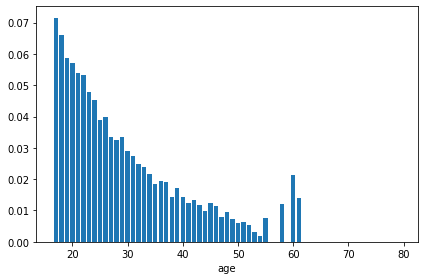

minimum age = 17


In [9]:
age_bin=data.groupby(['age'])['converted'].mean()
age_bin=age_bin.reset_index()
plt.bar(age_bin.age, age_bin.converted)
plt.xlabel('age')
plt.show()
print('minimum age =', data.age.min())

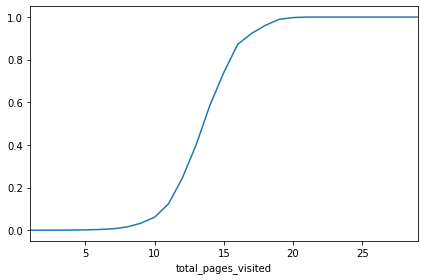

In [10]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

## Machine Learning ##

In [11]:
#dummy variables for the categorical ones
data_dummy = pandas.get_dummies(data, drop_first=True)
data_dummy.head(3)

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1


In [12]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print("OOB accuracy is", rf.oob_score_, "\n", "OOB Confusion Matrix", "\n",
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


In [14]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)


Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


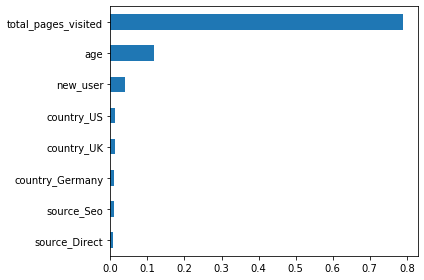

In [15]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

#### Total pages visited is clearly the feature with the highest importance in RF model. We will also try building the model without the feature to test the performances

In [16]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

#print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)


OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978
Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


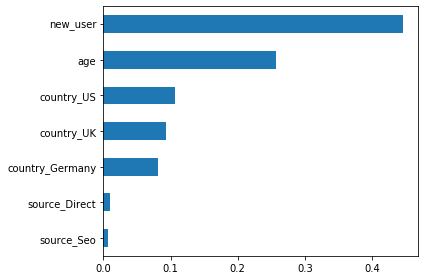

In [17]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

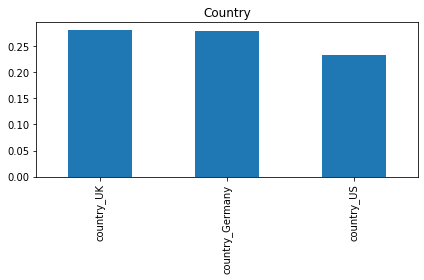

In [18]:
#!pip install pdpbox
from pdpbox import pdp, info_plots
  
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()


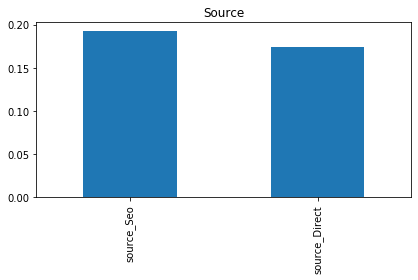

In [19]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

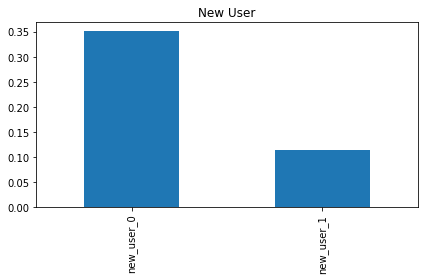

In [20]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()


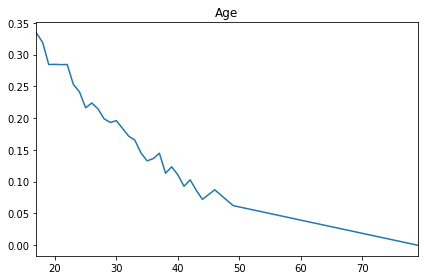

In [21]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

This shows that:

- Users with an old account are much better than new users

- Germany, UK, and US are similar, with Germany being the best. Most importantly, they all have very very high values. We could read this as relative to the reference level, which is China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. That is, China is very bad for conversion

- The site works very well for young people and gets worse for >30 yr old

- Source is less relevant



In [31]:
#!pip install graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  

tree.score(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
# s.view()

0.8199147060232881

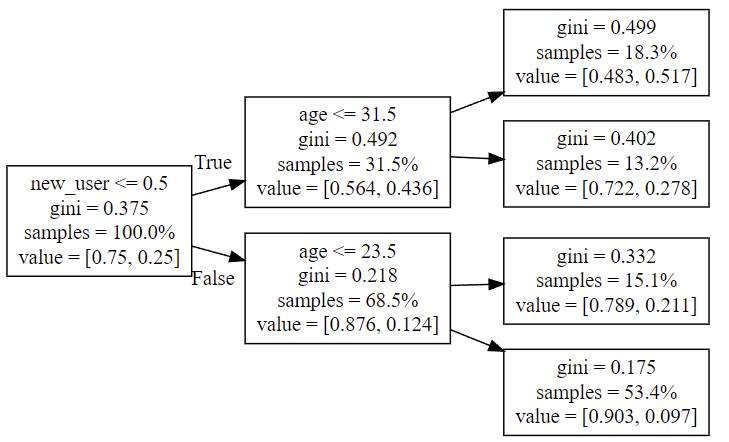

In [42]:
from IPython.display import Image
Image(filename='tree_conversion.png',width=50,height=50) 

Conclusions and next steps:

- The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

- The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Shoud target marketing towards getting more German users. Big opportunity.

- Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

- Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

- Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.